# Vasicek Model

## Imports

In [1]:
import pickle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
from noise import brown_noise, pink_noise, white_noise, blue_noise, violet_noise
from noise import estimate_covariance_matrix

In [4]:
from vasicek_model import VasicekModel, CalibrateVasicek

## Noise

In [5]:
noise_fns = {
    'brown' : brown_noise,
    'pink' : pink_noise,
    'white' : white_noise,
    'blue' : blue_noise,
    'violet' : violet_noise
}

## Data

https://fred.stlouisfed.org/series/FF
https://fred.stlouisfed.org/series/FEDFUNDS

Daily FEDFUNDS: https://fred.stlouisfed.org/series/DFF


In [6]:
interest_rates = pd.read_csv('DFF.csv')

In [7]:
interest_rates

,DATE,DFF
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88
...,...,...
25405,2024-01-20,5.33
25406,2024-01-21,5.33
25407,2024-01-22,5.33
25408,2024-01-23,5.33


In [8]:
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'], format='%Y-%m-%d')
interest_rates = interest_rates.rename(columns={'DFF': 'RATE'})
interest_rates['RATE'] = interest_rates['RATE'] / 100

In [9]:
(interest_rates.DATE[1:].reset_index(drop=True) - interest_rates.DATE[:-1]).value_counts()

1 days    25409
Name: DATE, dtype: int64

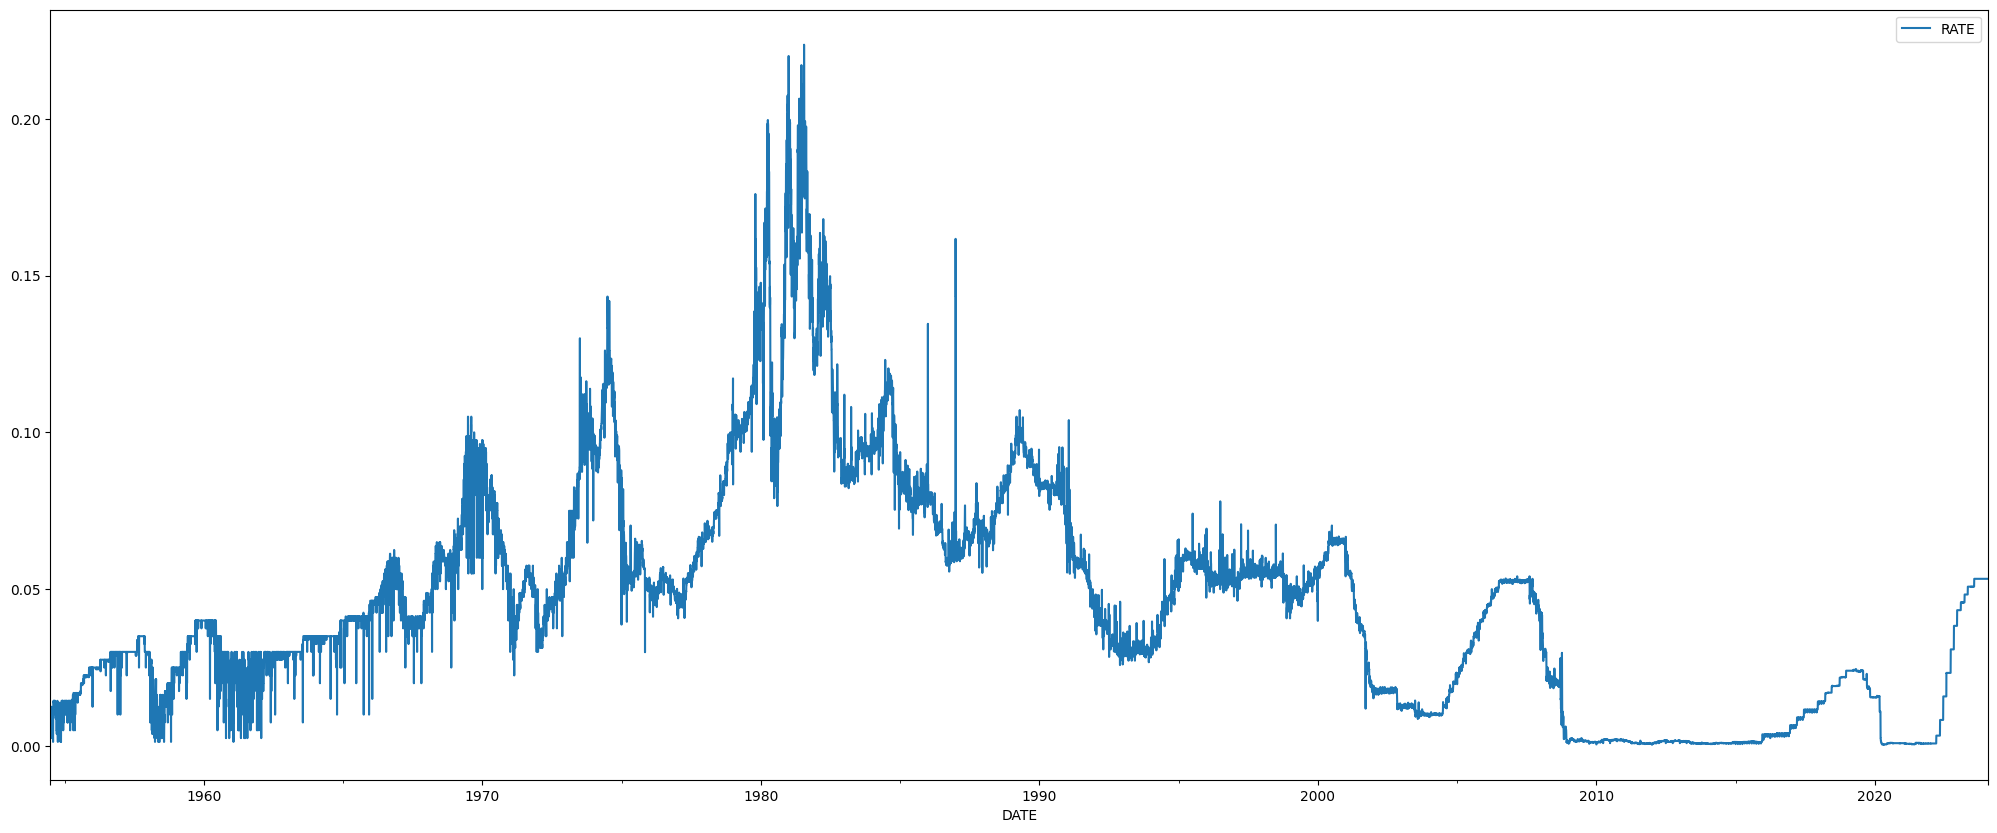

In [10]:
fig, ax = plt.subplots(figsize=(25, 10))
interest_rates[:].plot(x='DATE', y='RATE', ax=ax)
plt.show()

Periods with complications:

https://www.investopedia.com/thmb/NA4GVAouv419kZxf0WETZ0QMOdk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/dotdash_INV-final-Stock-Market-Crash-July-2021-01-88a96c7bec2846dd9986a5777c089417.jpg
https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions#/media/File:Federal_funds_rate_history_and_recessions.png

In [11]:
rate_series = interest_rates[(interest_rates.DATE >= '1993-01-01') & (interest_rates.DATE <= '1999-11-06')]

In [12]:
rate_series.head()

,DATE,RATE
14064,1993-01-01,0.0266
14065,1993-01-02,0.0266
14066,1993-01-03,0.0266
14067,1993-01-04,0.0360
14068,1993-01-05,0.0333


In [13]:
len(rate_series)

2501

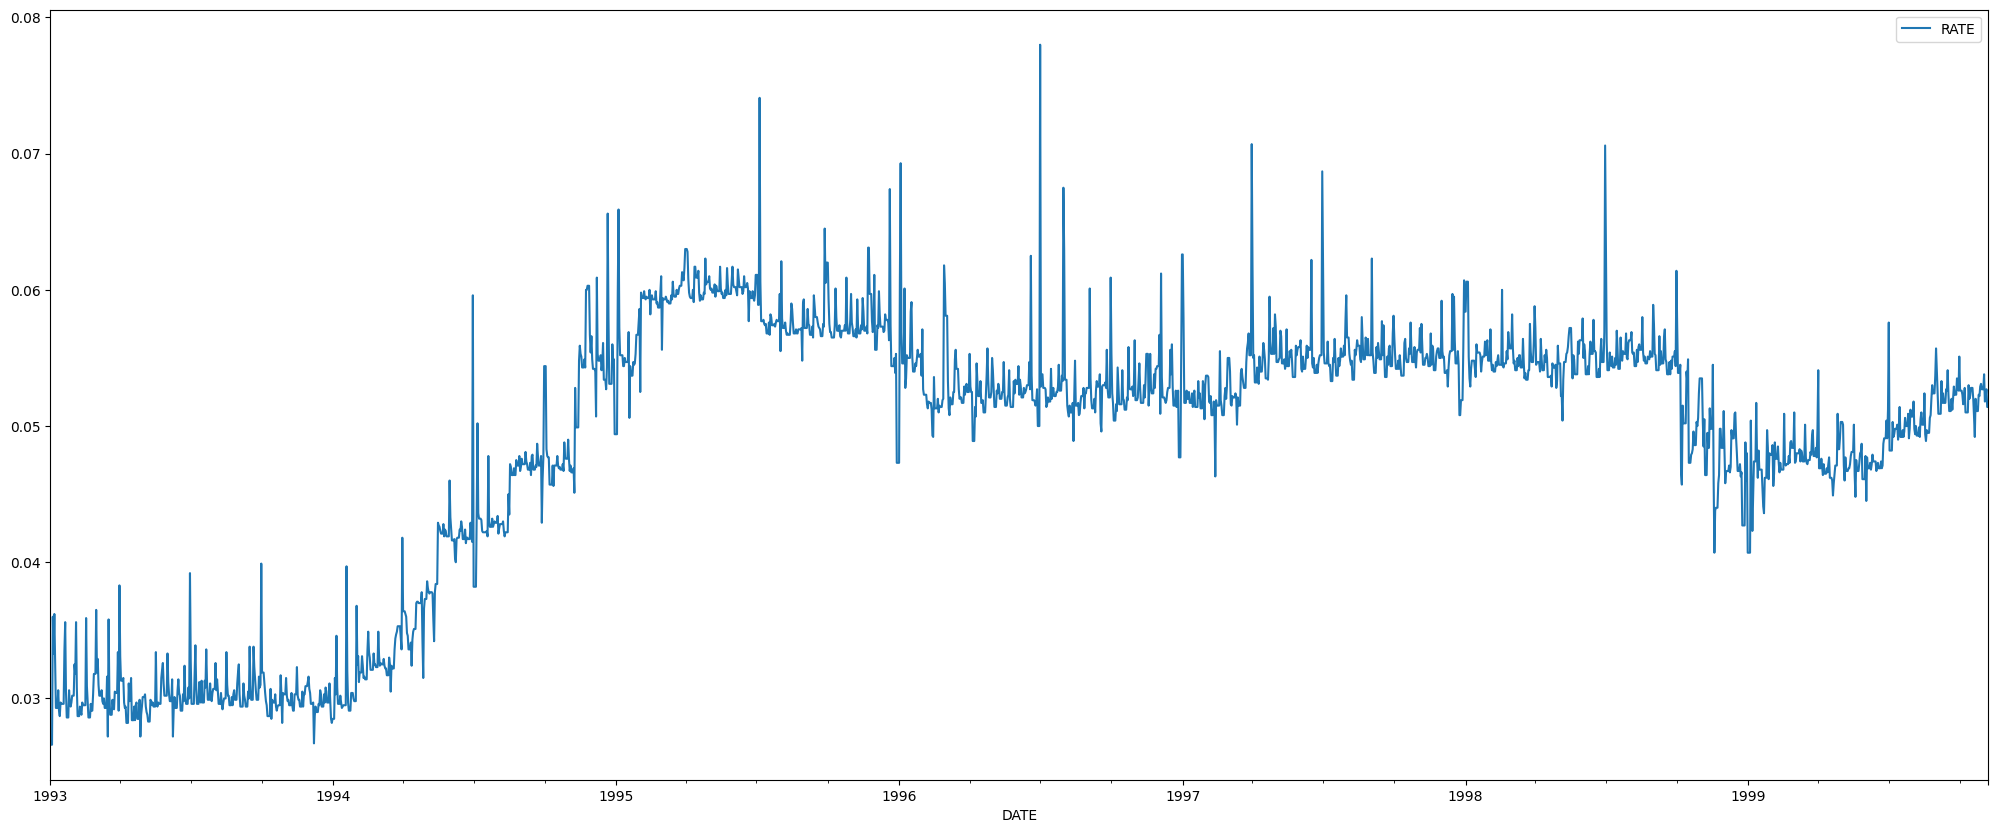

In [14]:
fig, ax = plt.subplots(figsize=(25, 10))
rate_series.plot(x='DATE', y='RATE', ax=ax)
plt.show()

In [15]:
r = np.array(rate_series.RATE)

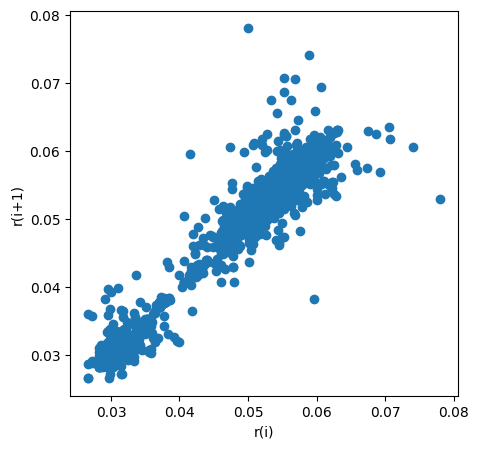

In [16]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(r[:-1], r[1:])
plt.xlabel('r(i)')
plt.ylabel('r(i+1)')
plt.show()

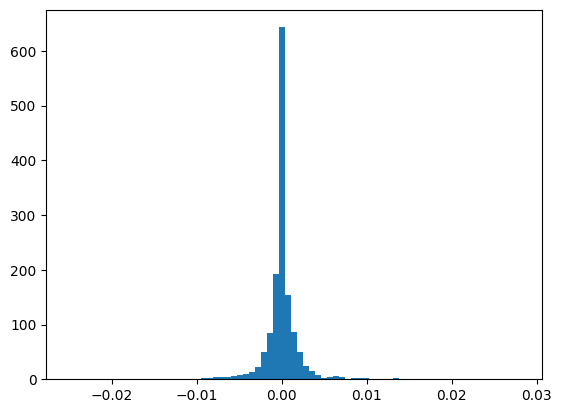

In [17]:
plt.hist(r[1:]-r[:-1], bins=75, density=True)
plt.show()

# Calibrate Vasicek Model

In [18]:
r = np.array(rate_series.RATE)

$dr_t = \kappa(\theta - r_t)dt + \sigma \vartheta_t$


### Calibrating using least squares regression

Stochastic differential equation Solution:
https://web.archive.org/web/20150619164944/http://www.sitmo.com/article/calibrating-the-ornstein-uhlenbeck-model/

$r_{i+1} = r_{i}e^{-\kappa \delta t} + \theta(1-e^{-\kappa \delta t}) + \sqrt{\frac{1-e^{-2\kappa\delta t}}{2\kappa}}N(0, 1)$

When exact solution is not known,

Approximate stochastic differential equation solution:

Euler Maruyama Scheme:
https://victor-bernal.weebly.com/uploads/5/3/6/9/53696137/projectcalibration.pdf

Euler Maruyama approx numerical solution

$r_{t+\Delta t} - r_t = \kappa(\theta - r_t)\Delta t + \sqrt{\Delta t}\sigma\vartheta_t$

$r_{t+\Delta t} = (1 - \kappa \Delta t)r_t +\kappa\theta\Delta t + \sqrt{\Delta t}\sigma\vartheta_t$

### Calibration using OLS on analytical solution for white noise

In [19]:
CalibrateVasicek.vasicek_gls_calibration(r, np.eye(len(r)-1))

(68.00904543963182,
 0.049043439863249084,
 0.11232339039715111,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7e2dcf0b1090>)

### Calibration using OLS on Euler Maruyama approximate solution for white noise

In [20]:
CalibrateVasicek.vasicek_em_gls_calibration(r, np.eye(len(r)-1))

(67.09233084880778,
 0.049043439863249084,
 0.11081276598079676,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7e2dce5543a0>)

#### Estimate colour noise covariance matrix

In [21]:
# cov_matrix = dict()
# for colour in ['brown', 'pink', 'white', 'blue', 'violet']:
#     cov_matrix[colour] = estimate_covariance_matrix(noise_fns[colour], (len(r)-1), int(1e6))

In [22]:
# with open('cov_matrix.pickle', 'wb') as handle:
#     pickle.dump(cov_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

# Read the file from Google Drive
with open('/content/drive/My Drive/NRU_MDS_Thesis/cov_matrix.pickle', 'rb') as handle:
    cov_matrix = pickle.load(handle)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
np.linalg.norm(cov_matrix['white']-np.eye(len(r)-1))

2.501644951809513

### Calibration using GLS with estimated covariance on Euler Maruyama approximate solution for white noise

In [31]:
CalibrateVasicek.vasicek_em_gls_calibration(r, cov_matrix['white'])

(66.31612269301034,
 0.049006698462818785,
 0.11094645880946619,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7e2dcd943cd0>)

#### Estimate parameters of coloured vasicek models

In [32]:
vm_params = dict()
gls_results = dict()
for colour in ['brown', 'pink', 'white', 'blue', 'violet']:
    kappa, theta, sigma, results = CalibrateVasicek.vasicek_em_gls_calibration(r, cov_matrix[colour])
    gls_results[colour] = (results,)
    vm_params[colour] = (kappa, theta, sigma)

In [33]:
vm_params

{'brown': (3464.7001984322155, 0.0486809579064803, 1.874280734914292),
 'pink': (2361.469329204108, 0.04868430193610039, 0.17806999575320479),
 'white': (66.31612269301034, 0.049006698462818785, 0.11094645880946619),
 'blue': (3.4985331778791817, 0.05576248509710164, 0.1171181357069998),
 'violet': (3.8910887667253924, 0.055047337455714336, 0.5918007687713407)}

# Generate syntheric time series using Vasicek Model

## Vasicek Model

$dr_t = \kappa(\theta - r_t)dt + \sigma \vartheta_t$

### Set parameters

In [35]:
horizon = 1
delta_t = 1/10000
r_0 = r[0]

In [36]:
vm_objects = {colour: VasicekModel(*vm_params[colour], horizon, delta_t, r_0, noise_fns[colour]) for colour in ['brown', 'pink', 'white', 'blue', 'violet']}

In [37]:
vm_series = {colour: vm_objects[colour].generate_rate_time_series() for colour in ['brown', 'pink', 'white', 'blue', 'violet']}

In [38]:
with open('vm_series.pickle', 'wb') as handle:
    pickle.dump(vm_series, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# with open('vm_series_0.pickle', 'rb') as handle:
#     vm_series = pickle.load(handle)

In [41]:
def plot_vm_color_series():
    fig, ax_list = plt.subplots(5, 1, figsize=(14, 22), tight_layout=True)
    i = 0
    for c, l in zip(
            ['brown', 'pink', 'gray', 'blue', 'violet'],
            ['brown', 'pink', 'white', 'blue', 'violet']):
        ax = ax_list[i]
        t, r = vm_series[l]
        ax.plot(t, r, color=c, label=l)
        ax.set_title(l)
        i += 1

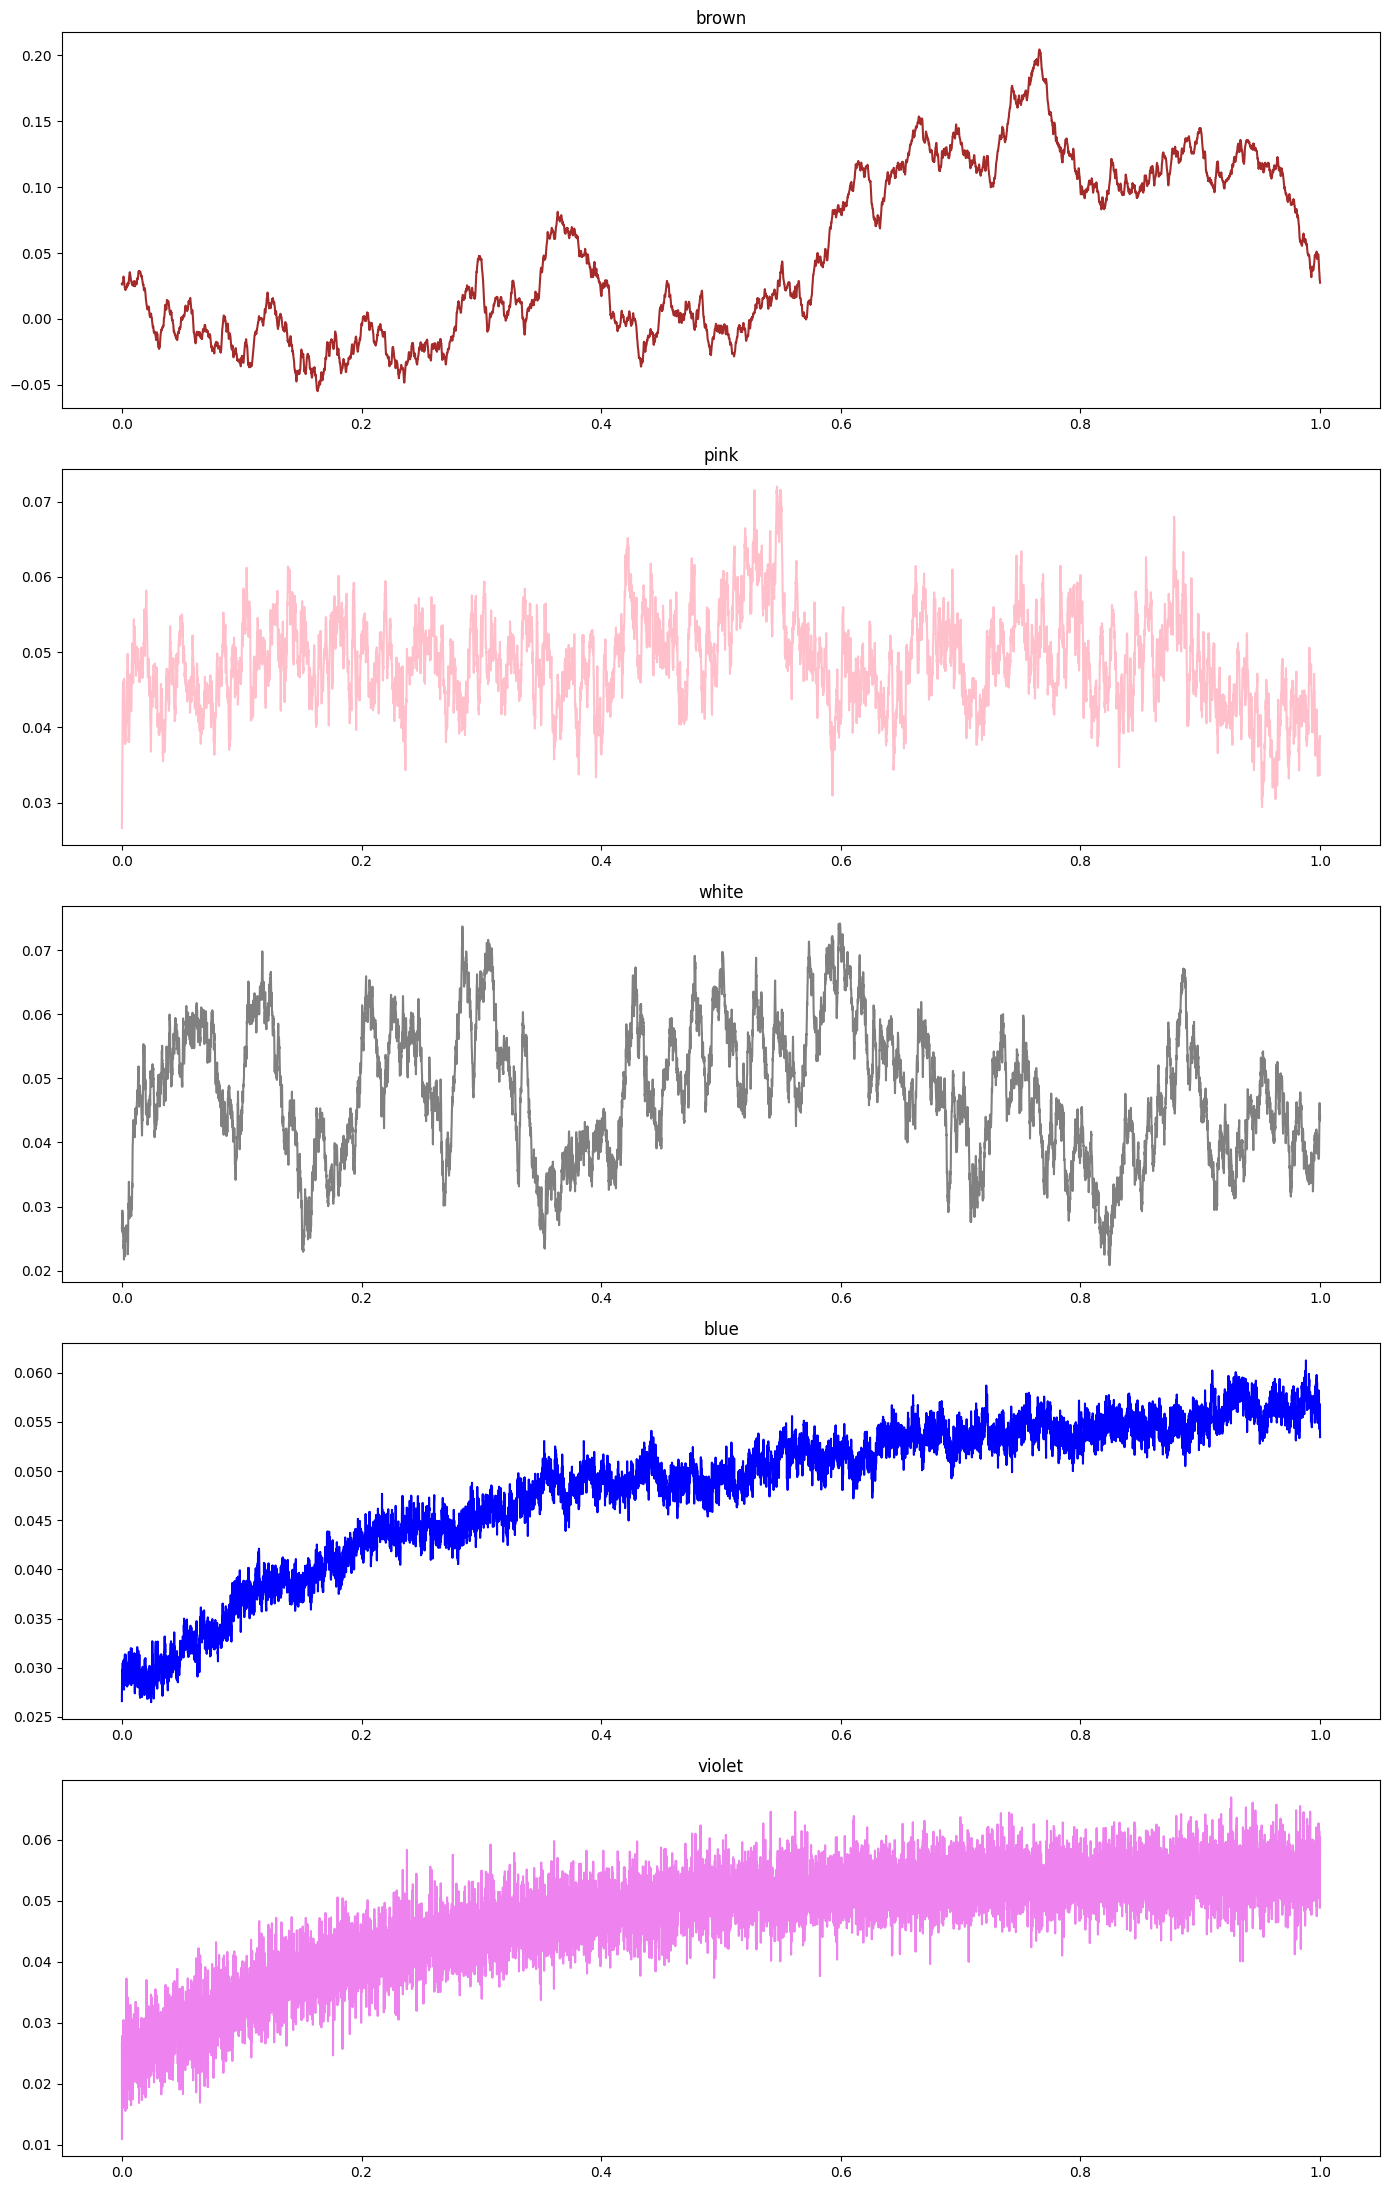

In [42]:
plot_vm_color_series()
plt.show()

# Try:

## Calibrated simulation bounds

In [ ]:
def plot_monte_carlo_simulation_vm(color, num_sim=10000):
    fig, ax = plt.subplots(figsize=(20, 10))
    avg_r = np.zeros(2501)
    for i in range(num_sim):
        model = VasicekModel(*vm_params[color], horizon, delta_t, r_0, noise_fns[color])
        t, r = model.generate_rate_time_series()
        avg_r += r
        c = 'gray' if color == 'white' else color
        ax.plot(t, r, color=c, label=color)
    ax.plot(t, avg_r/num_sim, color='black', label=color)
    ax.plot(t, VasicekModel(*vm_params[color][:2], 0, horizon, delta_t, r_0, noise_fns[color]).generate_rate_time_series()[1], color='green', label=color)
    plt.show()

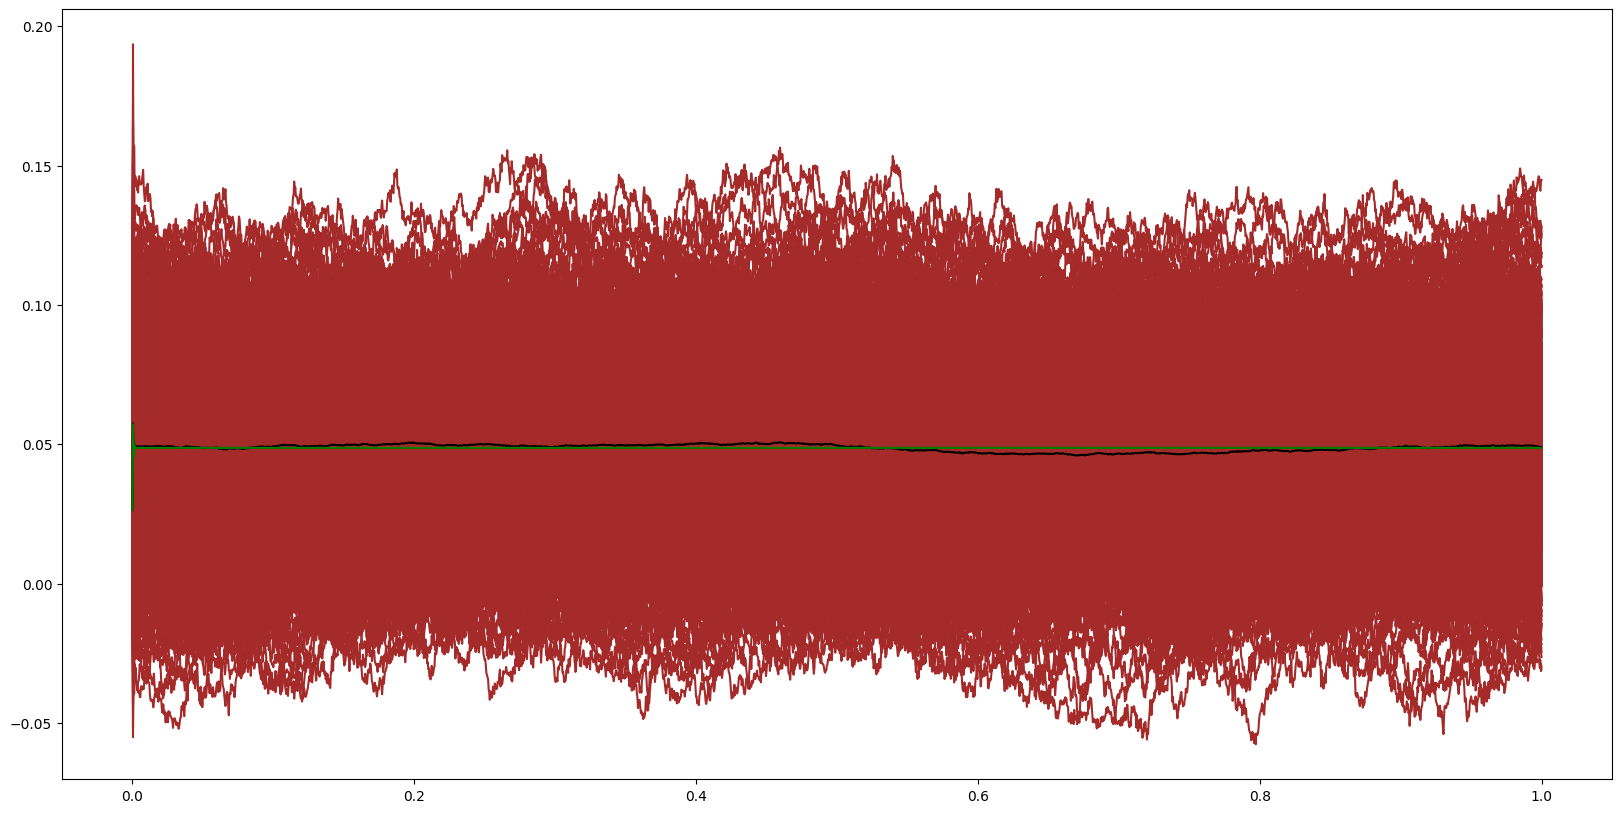

In [ ]:
plot_monte_carlo_simulation_vm('brown', num_sim=1000)

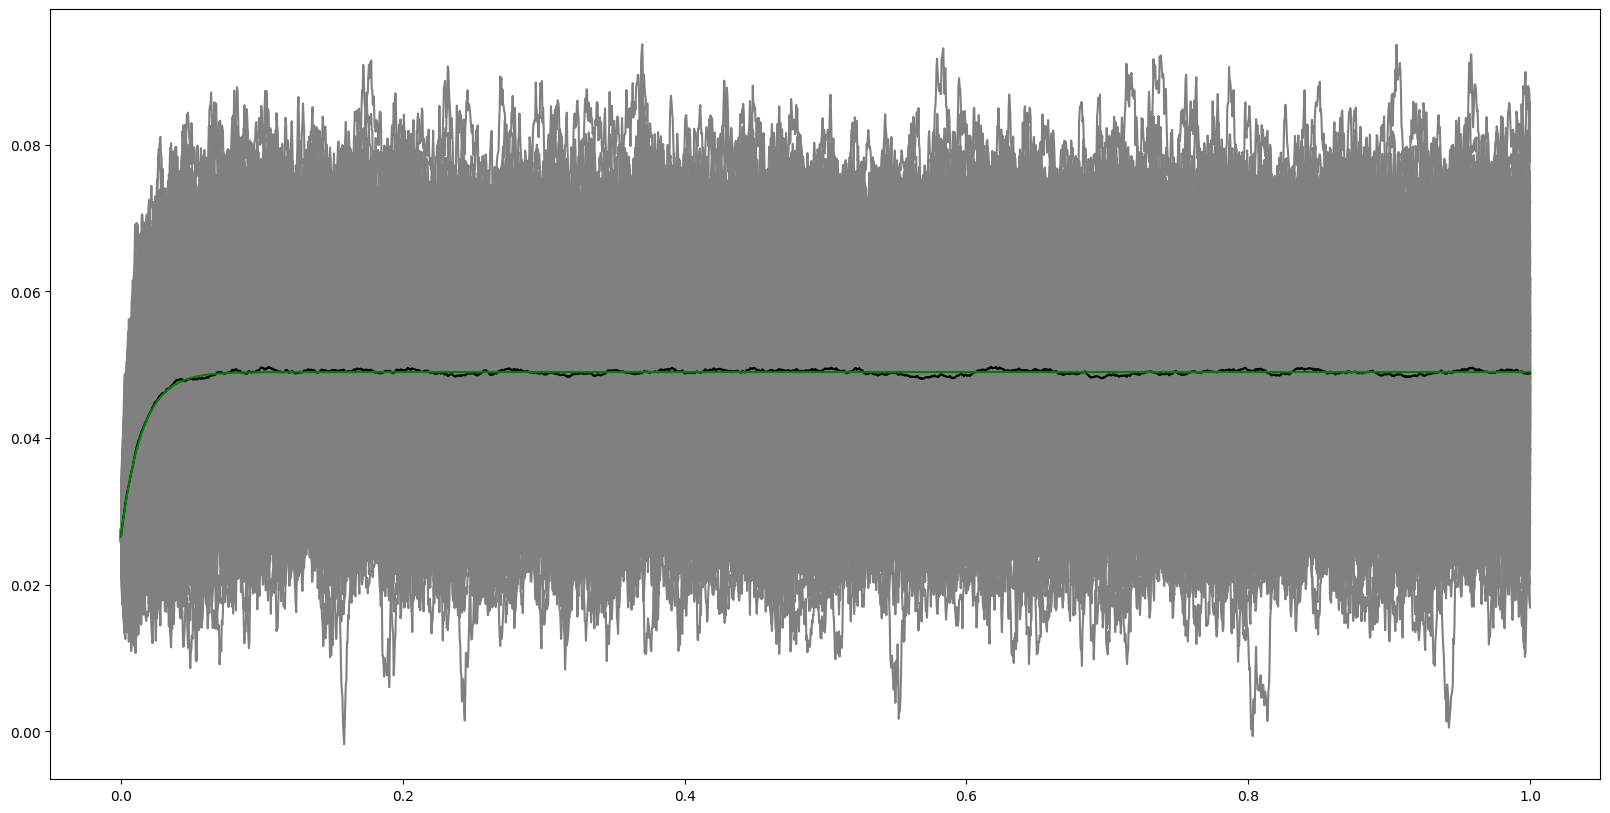

In [ ]:
plot_monte_carlo_simulation_vm('white', num_sim=1000)

Ideas to explore:
- Linear Regression with autocorrelated / heteroscedastic errors:
    AR, MA, ARIMA
- Gradient descent approach, MSE (heavy loss when it goes out of bounds [0, 100])

## Gradient Decent

$dr_t = \kappa(\theta - r_t)dt + \sigma \vartheta_t$

$r_{t+\Delta t} - r_t = \kappa\theta\Delta t - \kappa r_t\Delta t + \sqrt{\Delta t}\sigma\vartheta_t$

$r_{t+\Delta t} = (1 - \kappa \Delta t)r_t +\kappa\theta\Delta t + \sqrt{\Delta t}\sigma\vartheta_t$

$y = \alpha x + \beta + \varepsilon$

$\kappa = (1 - \alpha) / \Delta t$

$\theta = (1 - \alpha) / \Delta t$

$y = $

In [ ]:
class vasicek_loss:

    def __init__(self, delta_t, noise_fn, r_true):
        self.delta_t = delta_t
        self.noise_fn = noise_fn
        self.r_true = r_true
        self.r_pred = None
        self.model = None
        self.noise_series = None

    def loss_fn(self, w):
        a, b, sigma = w
        self.model = VasicekModel(a, b, sigma, horizon, delta_t, r_0, self.noise_fn)
        self.noise_series = self.model.noise_series
        _, self.r_pred = self.model.generate_rate_time_series()
        residual = self.r_true - self.r_pred[0::100]
        mse_loss = (sum(residual*residual))/(2*len(self.r_true))
        l2_reg = (a**2+b**2+sigma**2)
        loss = mse_loss #+ l2_reg
        return loss

    def loss_fn_grad(self, w):
        loss = self.loss_fn(w)
        a, b, sigma = w
        residual = self.r_true - self.r_pred[0::100]
        da, db, dsigma = 0, 0, 0
        da = sum(residual * self.delta_t * (self.r_pred[0::100] - b)) #+ 2*a*len(self.r_true)*0.00000001
        db = sum(- residual * self.delta_t * a) #+ 2*b*len(self.r_true)*0.00000001
        dsigma = sum(- residual[1:] * np.sqrt(delta_t) * self.noise_series[99::100]) #+ 2*sigma*len(self.r_true)*0.00000001
        grad = np.array((da, db, dsigma)) / len(self.r_true)
        return grad



In [ ]:
import gradient_descent as gd

In [ ]:
def find_local_opt(grad_descent, w_0):
    """
    Performs gradient descent algorithm with the passed instance of a gradient descent class

    Parameters
    ----------
    grad_descent: GradientDescent(or its subclass)
                  gradient descent object which defines the descent process
    w_0: array_like
         initial weight parameter

    Returns
    -------
    out: tuple
         Class instance after performing gradient descent iterations,
         Local minimum found by gradient descent,
         and the value of target function at local minimum
    """
    x_min, f_min, iterations = grad_descent.iterate(w_0, max_iter=int(1e5))
    return (grad_descent, x_min, f_min, iterations)

In [ ]:
vl = vasicek_loss(delta_t, brown_noise, np.array(rate_series.RATE))

In [ ]:
f = vl.loss_fn
grad_f = vl.loss_fn_grad

In [ ]:
w = np.array([a,b,sigma])
w

array([0.99323355, 0.06704484, 0.04615796])

In [ ]:
agd = gd.AdamGradientDescent(f, grad_f)

In [ ]:
grad_obj, w_min, f_min, iterations = find_local_opt(agd, w)

In [ ]:
w

array([0.99323355, 0.06704484, 0.04615796])

In [ ]:
w_min

array([3.33556439e+02, 3.58914582e-02, 2.33371787e-03])

In [ ]:
len(grad_obj.history)

100001

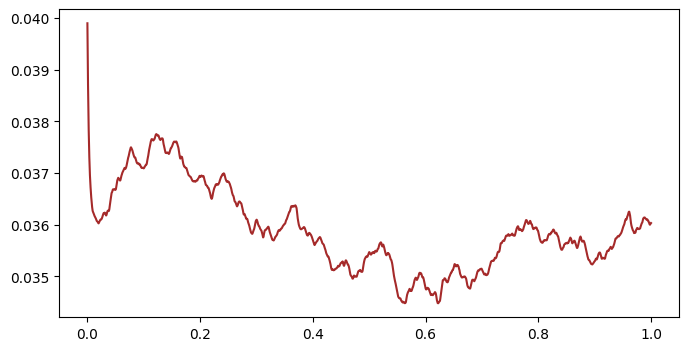

In [ ]:
model = VasicekModel(*w_min, horizon, delta_t, r_0, brown_noise)
fig, ax = plt.subplots(figsize=(8, 4))
t, r = model.generate_rate_time_series()
ax.plot(t, r, color='brown', label='brown')

In [ ]:
def plot_monte_carlo_simulation_vm(color, num_sim=10000):
    fig, ax = plt.subplots(figsize=(20, 10))
    avg_r = np.zeros(10001)
    for i in range(num_sim):
        model = VasicekModel(*w_min, horizon, delta_t, r_0, noise_fn[color])
        t, r = model.generate_rate_time_series()
        avg_r += r
        c = 'gray' if color == 'white' else color
        ax.plot(t, r, color=c, label=color)
    ax.plot(t, avg_r/num_sim, color='black', label=color)
    ax.plot(t, VasicekModel(a, b, 0, horizon, delta_t, r_0, noise_fn[color]).generate_rate_time_series()[1], color='green', label=color)
    plt.show()

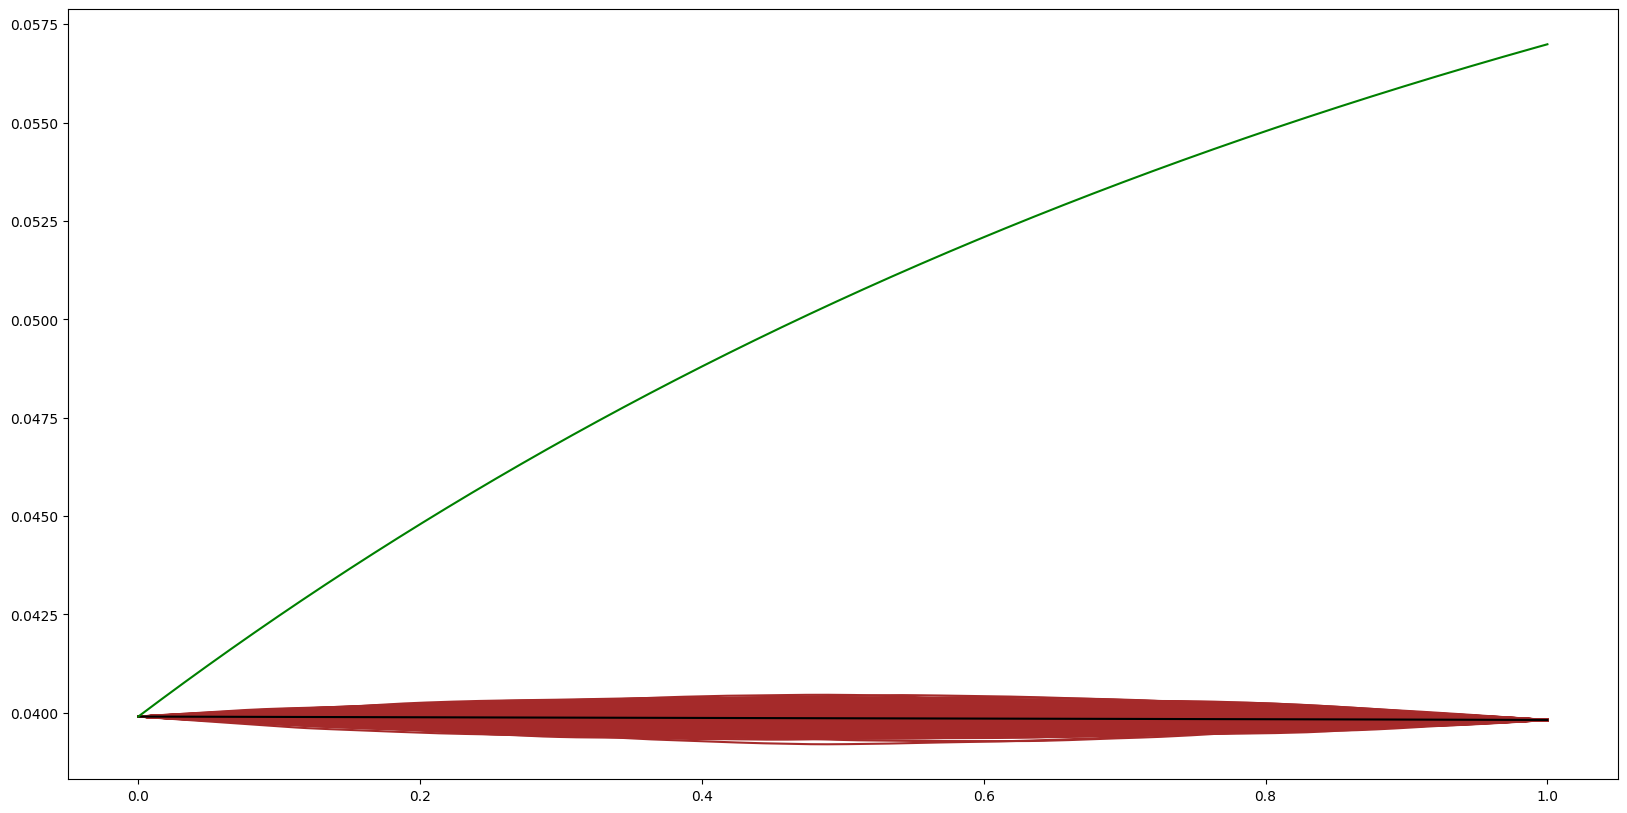

In [ ]:
plot_monte_carlo_simulation_vm('brown', num_sim=10000)

In [ ]:
vl = vasicek_loss(delta_t, white_noise, np.array(rate_series.RATE))

In [ ]:
f = vl.loss_fn
grad_f = vl.loss_fn_grad

In [ ]:
w = np.array([a,b,sigma])
w

array([0.99323355, 0.06704484, 0.04615796])

In [ ]:
agd = gd.AdamGradientDescent(f, grad_f)

In [ ]:
grad_obj, w_min, f_min, iterations = find_local_opt(agd, w)

In [ ]:
w

array([0.99323355, 0.06704484, 0.04615796])

In [ ]:
w_min

array([ 3.43498132e+02,  3.59095353e-02, -2.79669883e-03])

In [ ]:
len(grad_obj.history)

100001

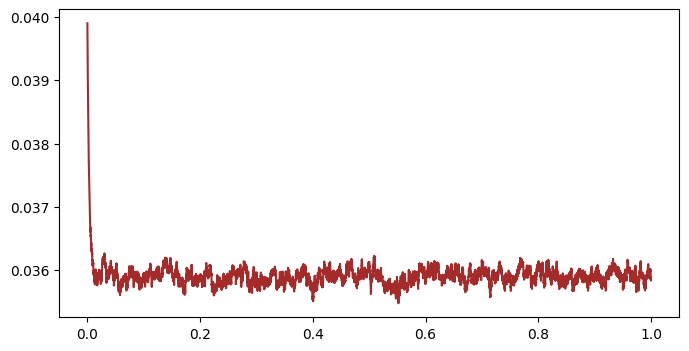

In [ ]:
model = VasicekModel(*w_min, horizon, delta_t, r_0, white_noise)
fig, ax = plt.subplots(figsize=(8, 4))
t, r = model.generate_rate_time_series()
ax.plot(t, r, color='brown', label='brown')

In [ ]:
f_min

In [ ]:
vl.loss_fn(w_min)

5.425126749839307e-05

In [ ]:
vl.loss_fn(w)

0.00021465943620525588

## noise anomaly

In [ ]:
t, r = vm_series['white']

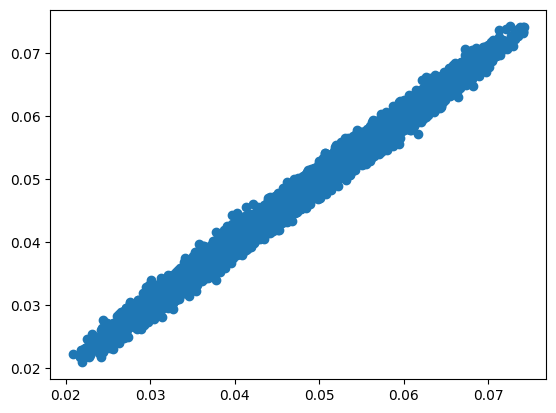

In [ ]:
plt.scatter(r[:-1], r[1:])

{'whiskers': [<matplotlib.lines.Line2D at 0x7ca66ae99de0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ca66b5cc700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ca66ae99990>],
 'medians': [<matplotlib.lines.Line2D at 0x7ca66ae99600>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ca66ae9b430>],
 'means': []}

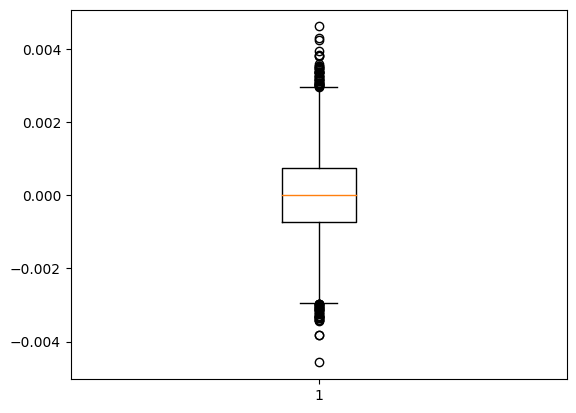

In [ ]:
plt.boxplot(r[1:]-r[:-1])

(array([3.000e+00, 6.100e+01, 4.230e+02, 1.568e+03, 3.045e+03, 2.924e+03,
        1.505e+03, 4.120e+02, 5.200e+01, 7.000e+00]),
 array([-4.57339393e-03, -3.65498428e-03, -2.73657463e-03, -1.81816498e-03,
        -8.99755327e-04,  1.86543230e-05,  9.37063973e-04,  1.85547362e-03,
         2.77388327e-03,  3.69229292e-03,  4.61070257e-03]),
 <BarContainer object of 10 artists>)

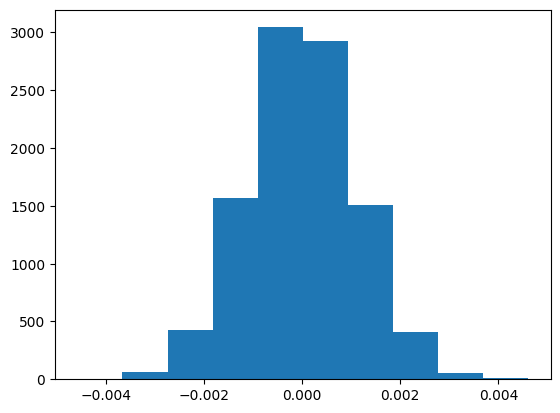

In [ ]:
plt.hist(r[1:]-r[:-1])

In [ ]:
def plot_consecutive_diff(color):
    fig, ax = plt.subplots(figsize=(8, 4))
    t, r = vm_series[color]
    ax.hist(r[1:]-r[:-1], label=color)
    ax.set_xlabel('r_t')
    ax.set_ylabel('r_{t+1} - r_t')

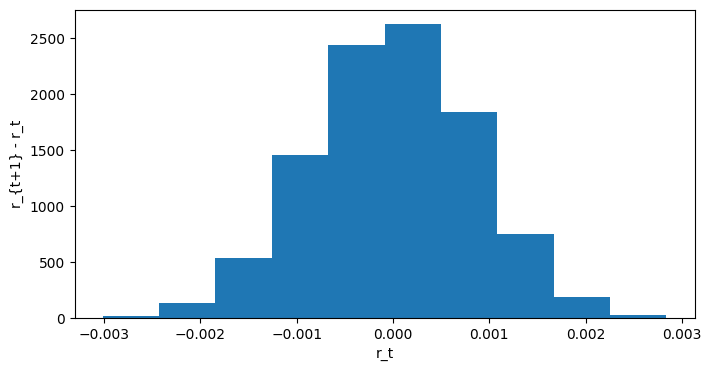

In [ ]:
plot_consecutive_diff('brown')
plt.show()

In [ ]:
def plot_consecutive_differences():
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))
    for i, color in enumerate(['brown', 'pink', 'white', 'blue', 'violet']):
        t, r = vm_series[color]
        ax[i].hist(r[1:]-r[:-1], color=(color if color!='white' else 'gray'), label=color)

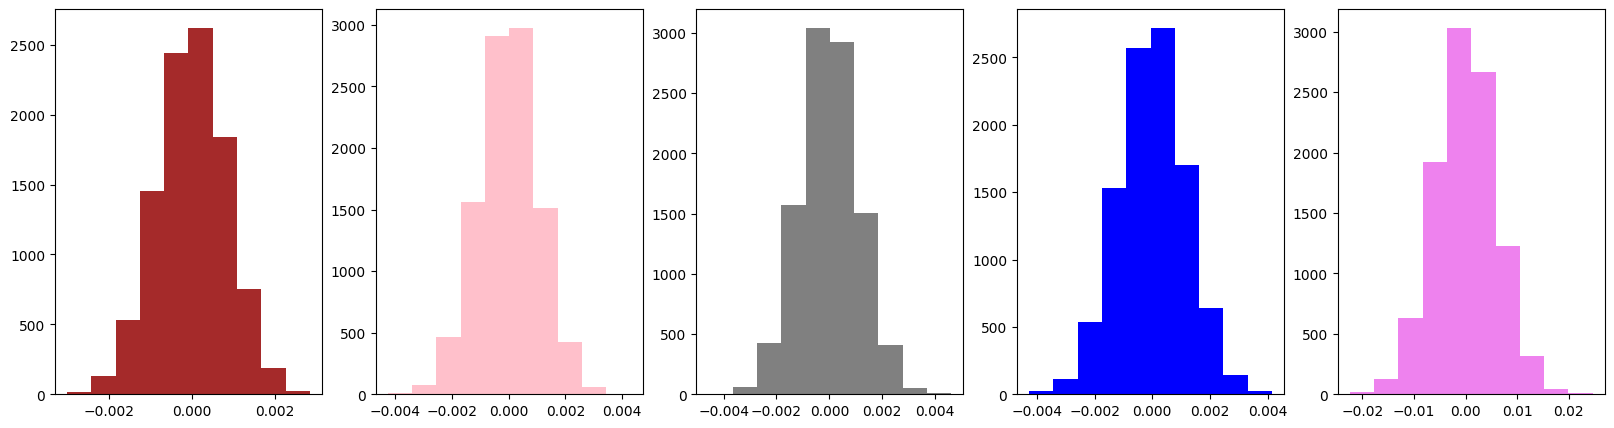

In [ ]:
plot_consecutive_differences()
plt.show()